# Colab Notebook for experiments on BigGAN generator

# Installing BIGGAN

In [ ]:
#google drive prefixes
imagenet_path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/imagenet"
path_drive = "/content/drive/MyDrive/Colab Notebooks/CV/project/"

In [ ]:
!pip install pytorch-pretrained-biggan

# import packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import nltk
nltk.download('wordnet')

import matplotlib.pyplot as plt
import pickle 
from tqdm import tqdm
import torch

from colornet_dataset import INColorDataset, get_dataloader
from colornet import ColorNet

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Using the GPU!


# Obtaining Dataset (Imagenet)

In [ ]:

%mkdir imagenet 
%cd imagenet 
!tar -xvf "/content/drive/MyDrive/Colab Notebooks/CV/project/ILSVRC2012_img_val.tar"
%cd /content

# Train Model


In [ ]:

# Only train encoder and FC layer parameters

colornet = ColorNet().to(device)

trainables = []
trainables.extend(colornet.encoder.parameters())
trainables.extend(colornet.fc1.parameters())
trainables.extend(colornet.fc2.parameters())
trainables.extend(colornet.bn1.parameters())
trainables.extend(colornet.bn2.parameters())

In [ ]:
optimizer = torch.optim.Adam(trainables, lr = 0.005, betas = (0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.1)
truncation = 0.1

In [ ]:
def evaluate(model, dataloader):
    running_loss = 0

    model.eval()
    with torch.no_grad():
        for g, c, gt in dataloader:

            g = g.to(device)
            c = c.to(device)
            gt = gt.to(device)

            out, _, _ = model(g, truncation = 1, gt=gt)
            loss = nn.MSELoss()(out, c)
            
            # statistics
            running_loss += loss.item() * g.size(0)

    print('Evaluation Loss: {:.4f}'.format(running_loss / len(dataloader.dataset)))
    return running_loss / len(dataloader.dataset)

In [ ]:

# standard training loop
def train_model(model, dataloaders, optimizer, scheduler, num_epochs=10):
    best_val_loss = 100000
    train_losses, val_losses = [], []


    for epoch in range(num_epochs):
        model.train()
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        running_loss = 0
        batches = tqdm(dataloaders["train"], total=len(dataloaders["train"]))

        for g, c, gt in batches:
            
            g = g.to(device)
            c = c.to(device)
            gt = gt.to(device)
            # c = rgb_to_lab(c)

            # zero the parameter gradients
            optimizer.zero_grad()

            out, _, _ = model(g, truncation = truncation, gt=gt)

            # #change out to LAB
            # out_lab = rgb_to_lab(out)

            # #normalize all LAB readings and retreive colors
            # c_colors = c[:, 1:, :, :] / 100
            # out_lab_colors = out_lab[:, 1:, :, :] / 100

            loss = nn.MSELoss()(out, c)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * g.size(0)

            batches.set_description(
              "Current Loss ({:.4e}), running total ({:.4e}) ".format(
                   loss.item(), running_loss
              )
            ) 
        if(scheduler is not None):
            scheduler.step()
        
        epoch_loss = running_loss / len(dataloaders["train"].dataset)
        print('Epoch Loss: {:.4f}'.format(epoch_loss))
        train_losses.append(epoch_loss)

        # evaluate loss on val
        val_loss = evaluate(model, dataloaders["val"])
        val_losses.append(val_loss)

        if(val_loss < best_val_loss):
            #saving this model
            print('\n Saving this model: \n')
            best_val_loss = val_loss
            torch.save(model.state_dict(), path_drive + "gt_trunc0.1.pt")

    
    return model, train_losses, val_losses

In [ ]:
dls = {split : get_dataloader("5k", 128, split) for split in ["train", "val", "test"]}

colornet, train_losses, val_losses = train_model(colornet, dls, optimizer, None, num_epochs = 50)

#saving all results
pickle.dump(train_losses, open(path_drive + "gt_trunc0.1_train_losses.pkl", 'wb'))
pickle.dump(val_losses, open(path_drive + "gt_trunc0.1_val_losses.pkl", 'wb'))

Epoch 1/50
----------


  0%|          | 0/94 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Current Loss (1.0027e-01), running total (3.0186e+02) : 100%|██████████| 94/94 [01:38<00:00,  1.04s/it]

Epoch Loss: 0.1006


Evaluation Loss: 0.1008

 Saving this model: 

Epoch 2/50
----------


Current Loss (9.2481e-02), running total (2.7780e+02) : 100%|██████████| 94/94 [01:35<00:00,  1.02s/it]

Epoch Loss: 0.0926


Evaluation Loss: 0.0890

 Saving this model: 

Epoch 3/50
----------


Current Loss (8.9117e-02), running total (2.6224e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]

Epoch Loss: 0.0874


Evaluation Loss: 0.0924
Epoch 4/50
----------


Current Loss (8.0958e-02), running total (2.5153e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0838


Evaluation Loss: 0.0834

 Saving this model: 

Epoch 5/50
----------


Current Loss (7.9564e-02), running total (2.4205e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0807


Evaluation Loss: 0.0801

 Saving this model: 

Epoch 6/50
----------


Current Loss (8.0960e-02), running total (2.3388e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0780


Evaluation Loss: 0.0797

 Saving this model: 

Epoch 7/50
----------


Current Loss (7.5885e-02), running total (2.2660e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]

Epoch Loss: 0.0755


Evaluation Loss: 0.0747

 Saving this model: 

Epoch 8/50
----------


Current Loss (8.5338e-02), running total (2.2071e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0736


Evaluation Loss: 0.0758
Epoch 9/50
----------


Current Loss (6.8256e-02), running total (2.1427e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0714


Evaluation Loss: 0.0705

 Saving this model: 

Epoch 10/50
----------


Current Loss (7.9932e-02), running total (2.0802e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0693


Evaluation Loss: 0.0716
Epoch 11/50
----------


Current Loss (6.9836e-02), running total (2.0382e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0679


Evaluation Loss: 0.0681

 Saving this model: 

Epoch 12/50
----------


Current Loss (7.9021e-02), running total (1.9853e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0662


Evaluation Loss: 0.0679

 Saving this model: 

Epoch 13/50
----------


Current Loss (7.1784e-02), running total (1.9594e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0653


Evaluation Loss: 0.0648

 Saving this model: 

Epoch 14/50
----------


Current Loss (5.5224e-02), running total (1.9170e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0639


Evaluation Loss: 0.0636

 Saving this model: 

Epoch 15/50
----------


Current Loss (5.4159e-02), running total (1.8809e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0627


Evaluation Loss: 0.0678
Epoch 16/50
----------


Current Loss (5.9956e-02), running total (1.8518e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0617


Evaluation Loss: 0.0615

 Saving this model: 

Epoch 17/50
----------


Current Loss (6.2362e-02), running total (1.8373e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0612


Evaluation Loss: 0.0607

 Saving this model: 

Epoch 18/50
----------


Current Loss (5.8437e-02), running total (1.7987e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0600


Evaluation Loss: 0.0606

 Saving this model: 

Epoch 19/50
----------


Current Loss (6.3288e-02), running total (1.7755e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0592


Evaluation Loss: 0.0607
Epoch 20/50
----------


Current Loss (5.2882e-02), running total (1.7602e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0587


Evaluation Loss: 0.0594

 Saving this model: 

Epoch 21/50
----------


Current Loss (6.2771e-02), running total (1.7377e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0579


Evaluation Loss: 0.0601
Epoch 22/50
----------


Current Loss (4.4249e-02), running total (1.7156e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0572


Evaluation Loss: 0.0579

 Saving this model: 

Epoch 23/50
----------


Current Loss (5.9480e-02), running total (1.7032e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0568


Evaluation Loss: 0.0579
Epoch 24/50
----------


Current Loss (4.7165e-02), running total (1.6823e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0561


Evaluation Loss: 0.0578

 Saving this model: 

Epoch 25/50
----------


Current Loss (5.0914e-02), running total (1.6693e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0556


Evaluation Loss: 0.0576

 Saving this model: 

Epoch 26/50
----------


Current Loss (6.0327e-02), running total (1.6563e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0552


Evaluation Loss: 0.0574

 Saving this model: 

Epoch 27/50
----------


Current Loss (5.2181e-02), running total (1.6455e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0549


Evaluation Loss: 0.0559

 Saving this model: 

Epoch 28/50
----------


Current Loss (6.2786e-02), running total (1.6298e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0543


Evaluation Loss: 0.0552

 Saving this model: 

Epoch 29/50
----------


Current Loss (5.3303e-02), running total (1.6115e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0537


Evaluation Loss: 0.0548

 Saving this model: 

Epoch 30/50
----------


Current Loss (6.8432e-02), running total (1.6033e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0534


Evaluation Loss: 0.0542

 Saving this model: 

Epoch 31/50
----------


Current Loss (6.3706e-02), running total (1.5965e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0532


Evaluation Loss: 0.0546
Epoch 32/50
----------


Current Loss (5.7640e-02), running total (1.5806e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0527


Evaluation Loss: 0.0529

 Saving this model: 

Epoch 33/50
----------


Current Loss (5.1023e-02), running total (1.5708e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0524


Evaluation Loss: 0.0532
Epoch 34/50
----------


Current Loss (5.3883e-02), running total (1.5594e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0520


Evaluation Loss: 0.0531
Epoch 35/50
----------


Current Loss (5.0949e-02), running total (1.5648e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0522


Evaluation Loss: 0.0542
Epoch 36/50
----------


Current Loss (5.5333e-02), running total (1.5486e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]

Epoch Loss: 0.0516


Evaluation Loss: 0.0522

 Saving this model: 

Epoch 37/50
----------


Current Loss (5.7539e-02), running total (1.5339e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0511


Evaluation Loss: 0.0519

 Saving this model: 

Epoch 38/50
----------


Current Loss (4.8857e-02), running total (1.5313e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0510


Evaluation Loss: 0.0517

 Saving this model: 

Epoch 39/50
----------


Current Loss (4.9668e-02), running total (1.5181e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0506


Evaluation Loss: 0.0519
Epoch 40/50
----------


Current Loss (4.6429e-02), running total (1.5193e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0506


Evaluation Loss: 0.0528
Epoch 41/50
----------


Current Loss (5.5846e-02), running total (1.5055e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0502


Evaluation Loss: 0.0505

 Saving this model: 

Epoch 42/50
----------


Current Loss (4.3528e-02), running total (1.5017e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0501


Evaluation Loss: 0.0516
Epoch 43/50
----------


Current Loss (4.6064e-02), running total (1.4940e+02) : 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]

Epoch Loss: 0.0498


Evaluation Loss: 0.0505

 Saving this model: 

Epoch 44/50
----------


Current Loss (4.7633e-02), running total (1.4788e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0493


Evaluation Loss: 0.0499

 Saving this model: 

Epoch 45/50
----------


Current Loss (4.8731e-02), running total (1.4773e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.00it/s]

Epoch Loss: 0.0492


Evaluation Loss: 0.0503
Epoch 46/50
----------


Current Loss (5.8766e-02), running total (1.4681e+02) : 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Epoch Loss: 0.0489


Evaluation Loss: 0.0494

 Saving this model: 

Epoch 47/50
----------


Current Loss (4.6534e-02), running total (1.4707e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0490


Evaluation Loss: 0.0495
Epoch 48/50
----------


Current Loss (5.7803e-02), running total (1.4619e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0487


Evaluation Loss: 0.0510
Epoch 49/50
----------


Current Loss (5.6332e-02), running total (1.4466e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0482


Evaluation Loss: 0.0504
Epoch 50/50
----------


Current Loss (5.0962e-02), running total (1.4354e+02) : 100%|██████████| 94/94 [01:34<00:00,  1.00s/it]

Epoch Loss: 0.0478


Evaluation Loss: 0.0502


# Model Evaluation

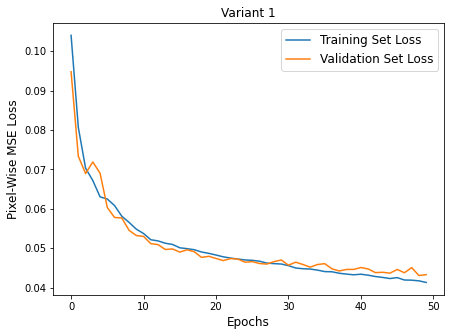

In [ ]:

train_losses = pickle.load(open(path_drive + "onehot_train_losses.pkl",'rb'))
val_losses = pickle.load(open(path_drive + "onehot_val_losses.pkl",'rb'))

#plotting losses

plt.figure(figsize=(7,5))
plt.plot(range(50), train_losses[:50], label = "Training Set Loss")
plt.plot(range(50), val_losses[:50], label = "Validation Set Loss")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Pixel-Wise MSE Loss", fontsize=12)
plt.title("Variant 1")
plt.legend(fontsize=12)


In [ ]:
# show some sample outputs

val_dataloader = get_dataloader('5k', 128, 'test')
out = None
with torch.no_grad():
    g, c, gt = iter(val_dataloader).next()
    g = g.to(device)
    c = c.to(device)
    gt = gt.to(device)

    out, encoding, _ = colornet(g, truncation = 0.1, gt=gt)



for i in range(16):
    fig, ax = plt.subplots(1,3, figsize=(10,30))
    ax[0].imshow(g[i].detach().cpu().numpy().transpose(1,2,0))
    ax[0].axis("off")
    ax[1].imshow(out[i].detach().cpu().numpy().transpose(1,2,0))
    ax[1].axis("off")
    ax[2].imshow(c[i].detach().cpu().numpy().transpose(1,2,0))
    ax[2].axis("off")